# Estudos ADR

## Pesquisadores: Luiz (UFJF), Álvaro (UFJF), Jessika (UFRN), Vicente Sousa (UFRN)

**Objetivos:**

- Analisar mudanças realizadas pelo grupo UFJF para implmentação de algoritmos de ADR;
- Criar path do código;
- Criar script para criar campanhas de simulação;
- Criar script para plotar campanha de simulação;
- Analisar novos resultados e comparar com os produzidos anteriormente.


# Processo de instalação

A instalação depende de três etapas:
- Baixar e instalar dependências;
- Baixar o repositório do código mais atual do ns-3 (ns-3.29);
- Baixar o repositório do código do LoRa (módulo em **https://github.com/signetlabdei/lorawan**) e mesclar com o código ns-3.29;
- Incorporar mudanças do Luiz Quirino (UFJF) com implementações de novos algoritmos de ADR (o código está na pasta **LoRa-Luiz-vicente**).

O script **ns3_full_installation.sh** foi construído para realizar as quatro etapas acima. Ele deve ser chamado da pasta do repositório do ns-3-lora-gppcom. Esse script já foi executado na pasta e o conteúdo gerado foi incorporado no repositório, objetivando tornar as demais etapas executáveis neste documento. 

Contudo, para não guardar todo o código compilado, você baixar o repositório, configurar e compilar o código.

- Para baixar o repositório, digite em um terminal:

```bash
git clone https://github.com/vicentesousa/ns-3-lora-gppcom.git
```

- Para entrar na pasta:

```bash
cd ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/
```
- Configurar:

```bash
CXXFLAGS="-Wall -g -O0" ./waf --build-profile=debug --disable-examples --disable-tests --disable-python configure
```

- Compilar:

```bash
./waf
```

# Processo de criação de campanha de simulação

Os processos de criação de uma campanha de simulação e de geração de gráficos estão vinculados a um arquivo de extensão **yaml**. Nele, a variação de parâmetros da camapanha de simulação é definido e será usado por duas função em python: uma que gerará a campanha de simulação (**plotScript.py**) e outro que plotará os gráficos (**plotScript.py**).

A seguir é mostrado um exemplo do arquivo **yaml** de configuração da campanha de simulação. Ao executar esse código no Jupyter Notebook (Shift+Enter), o arquivo **campanha_1.yaml** é gerado.

Esse código especifica (não gera ainda) uma camapanha de simulação com os parâmetros **radius** (2000, 4000, 6000, 8000, 10000) e **nDevices** (1000, 2000, 3000, 4000, 5000, 6000) para os valores do parâmetro **Algoritmo** variando de 1 a 5.

**Importante**: para que esse código funcione na sua máquina local, talvez você precise editar o parâmetro **ns3_path**, espeficiando o caminho completo do ns-3.

In [1]:
%%file campanha_1.yaml
scenario:
    # Output filename
    filename: DadosLora_1_job
    # Set location of simulation: local or cluster
    simLocation: local
    # Set campaign scenario: a name of one valid parameter
    #campaign: radius
    campaign: 
        - radius
        - nDevices
    # Number of jobs to run
    jobs: 1
    # Simulation duration (seconds)
    simulationTime: 600
    # Number of end devices to include in the simulation
    nDevices:
        - 1000
        - 2000 
        - 3000
        - 4000
        - 5000
        - 6000 
    # The radius of the area to simulate
    radius: 
        - 2000
        - 4000
        - 6000
        - 8000
        - 10000
    # The period in seconds to be used by periodically transmitting applications
    appPeriodSeconds: 600
    # Whether or not to print various informations
    bPrint: false
    # Fixed seed and run seed (set false for a long simulation campaign)
    fixedSeed: false
    # Algoritmo de ADR: 1 to 5
    Algoritmo: 
        - 1
        - 2
        - 3
        - 4
        - 5
    # Complete path of ns-3 simulator
    ns3_path: ns-allinone-3.29/ns-3.29
    # Script with the main code (inside scratch folder without .cc)
    ns3_script: ADR_code

Overwriting campanha_1.yaml


A seguir é criado o arquivo **campanha_2.yaml** para a mesma campanha de simulação, agora com 10 jobs.

In [11]:
%%file campanha_2.yaml
scenario:
    # Output filename
    filename: DadosLora_10_jobs    
    # Set location of simulation: local or cluster
    simLocation: local
    # Set campaign scenario: a name of one valid parameter
    #campaign: radius
    campaign: 
        - radius
        - nDevices
    # Number of jobs to run
    jobs: 10
    # Simulation duration (seconds)
    simulationTime: 600
    # Number of end devices to include in the simulation
    nDevices:
        - 1000
        - 2000 
        - 3000
        - 4000
        - 5000
        - 6000 
    # The radius of the area to simulate
    radius: 
        - 2000
        - 4000
        - 6000
        - 8000
        - 10000
    # The period in seconds to be used by periodically transmitting applications
    appPeriodSeconds: 600
    # Whether or not to print various informations
    bPrint: false
    # Fixed seed and run seed (set false for a long simulation campaign)
    fixedSeed: false
    # Algoritmo de ADR: 1 to 5
    Algoritmo: 
        - 1
        - 2
        - 3
        - 4
        - 5
    # Complete path of ns-3 simulator
    ns3_path: ns-allinone-3.29/ns-3.29
    # Script with the main code (inside scratch folder without .cc)
    ns3_script: ADR_code

Overwriting campanha_2.yaml


A seguinte função em python foi criada para, de posse do arquivo **yaml**, criar um arquivo **.sh** para rodar a campanha de simulação.  Ao executar esse código no Jupyter Notebook (Shift+Enter), o arquivo **loraScript.py** é gerado.

In [1]:
%%file loraScript.py
from collections import defaultdict
import os
import math
import random
import re
import subprocess
import sys
import argparse
from glob import glob
import numpy as np
import matplotlib.pylab as plt
from itertools import cycle
# To install YAML: sudo apt-get install python3-yaml
import yaml

class Simulation:
    def __init__(self, configurations_file):
        self.email_to = 'martinsdecastro23@gmail.com'            
        with open(configurations_file, 'r') as f:
            self.doc = yaml.load(f, Loader=yaml.loader.BaseLoader)
        self.campaign_name = os.path.splitext(configurations_file)[0]
        
        # Read commom parameters
        self.campaign = self.doc['scenario']['campaign']
        self.simLocation = str(doc['scenario']['simLocation'])
        self.simulationTime = self.doc['scenario']['simulationTime']
        self.nDevices = self.doc['scenario']['nDevices'][0]
        self.radius = self.doc['scenario']['radius'][0]
        self.appPeriodSeconds = self.doc['scenario']['appPeriodSeconds']
        self.bPrint = (self.doc['scenario']['bPrint'])
        self.fixedSeed = (self.doc['scenario']['fixedSeed'])
        self.algoritmo = self.doc['scenario']['Algoritmo']
        self.ns3_path = str(self.doc['scenario']['ns3_path'])
        self.ns3_path = os.getcwd() + '/' + self.ns3_path
        self.ns3_script = str(self.doc['scenario']['ns3_script'])
        self.nJobs = int(self.doc['scenario']['jobs'])
        self.filename = str(self.doc['scenario']['filename'])
       
    def runCampaign(self,curCampaign):
        # Configure simulation file in accordance with campaign parameter
        sh_name = self.campaign_name + '_' + self.simLocation + '_' + curCampaign
        print(curCampaign+" campaign written in file: " 'run_%s.sh' % sh_name)
        with open('run_all_%s.sh' % sh_name, 'w') as f:                    
            if self.simLocation == 'cluster':
              print('To be implemented')
            else:
              f.write('#!/bin/bash\n')
              f.write("cd '"+self.ns3_path+"'"+"\n")
              outputDir = self.ns3_path+'/results_'+self.simLocation + '_' + curCampaign
              #f.write('rm -rf '+outputDir+' 2>/dev/null\n')
              f.write('mkdir -p '+outputDir+'\n')
            for iJob in range(0, self.nJobs):
                jobRunSeed = random.randint(1, 23*10**14)
                for iAlg in self.algoritmo:                           
                    for varParam in self.doc['scenario'][curCampaign]:
                      if str(curCampaign) == 'radius':
                          command = (
                          'NS_GLOBAL_VALUE="RngRun='+str(jobRunSeed)+ '" ' +
                          "./waf --run '"+self.ns3_script+
                          " --radius="+varParam+
                          " --nDevices="+self.nDevices+
                          " --simulationTime="+self.simulationTime+
                          " --appPeriodSeconds="+self.appPeriodSeconds+
                          " --print="+self.bPrint+
                          " --fixedSeed="+str(self.fixedSeed)+
                          " --algoritmo="+iAlg+
                          " --filename="+ self.filename +
                          " --outputDir='"+outputDir+"'"
                          "'"
                          )
                      elif str(curCampaign) == 'nDevices':
                          command = (
                          'NS_GLOBAL_VALUE="RngRun='+str(jobRunSeed)+ '" ' +
                          "./waf --run '"+self.ns3_script+ 
                          " --radius="+self.radius+
                          " --nDevices="+varParam+
                          " --simulationTime="+self.simulationTime+
                          " --appPeriodSeconds="+self.appPeriodSeconds+
                          " --print="+self.bPrint+
                          " --fixedSeed="+str(self.fixedSeed)+
                          " --algoritmo="+iAlg+
                          " --filename="+ self.filename +
                          " --outputDir='"+outputDir+"'"
                          "'"
                          )
                      f.write(command+' & wait\n')
                      
parser = argparse.ArgumentParser()
parser.add_argument("-f", "--file", type=str, help='Configuration File')
args = parser.parse_args()

configurations_file = args.file; 
with open(configurations_file, 'r') as f:
    doc = yaml.load(f, Loader=yaml.loader.BaseLoader)
    campaign_name = os.path.splitext(configurations_file)[0]

print('Simulação escolhida: ')
campaign = doc['scenario']['campaign']
print(campaign)
                 
simu = Simulation(configurations_file)

for simC in campaign:
    if str(simC) == 'nDevices' or str(simC) == 'radius':
        simu.runCampaign(simC);
    else:
        print('Invalid simulation campaign: verify the campaign parameter!')

Overwriting loraScript.py


O Script **loraScript.py** recebe um arquivo **yaml** com parâmetro de entrada e gera os segugintes arquivos:

- **run_campanha_local_nDevices.sh**: com as chamadas para as simulações variando o número de dispositivos;
- **run_campanha_local_radius.sh**: com as chamadas para as simulações variando o raio.

Esses dois arquivos **.sh** devem ser chamados em um terminal, chamando as simulações especificas de cada caso.

Abaixo, o script **loraScript.py** é chamado para a **campanha_1.yaml** criada anteriormente.


In [2]:
%run loraScript -f "campanha_1.yaml"

Simulação escolhida: 
['radius', 'nDevices']
radius campaign written in file: run_campanha_1_local_radius.sh
nDevices campaign written in file: run_campanha_1_local_nDevices.sh


Para rodar o código em um terminal, digite:

```python
python3 loraScript.py -f 'campanha_1.yaml'
```


Ao rodar o **loraScript.py** com o arquivo **campanha_1.yaml** como parâmetro, os arquivos  **run_all_campanha_1_local_nDevices.sh** e **run_all_campanha_1_local_radius.sh** foram criados. Eles contém a chamada de código para as duas campanhas de simulação especificadas em **campanha_1.yaml**.

O código a seguir executa os dois arquivos **.sh** diretamente deste Jupyter Notebook.

In [4]:
!chmod +x ./run_all_campanha_1_local_nDevices.sh 
!./run_all_campanha_1_local_nDevices.sh


!chmod +x ./run_all_campanha_1_local_radius.sh
!./run_all_campanha_1_local_radius.sh

Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.880s)
simulation start at: Sun Oct  6 11:30:46 2019

Running with nDevices = 1000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3117423685, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sun Oct  6 11:30:59 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sun Oct  6 12:06:44 2019

Time elapsed: 6.05 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.414s)
simulation start at: Sun Oct  6 12:06:48 2019

Running with nDevices = 6000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 3117423685, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sun Oct  6 12:15:46 2019

Time elapsed: 8.96667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/buil

simulation start at: Sun Oct  6 12:41:55 2019

Running with nDevices = 4000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3117423685, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sun Oct  6 12:45:44 2019

Time elapsed: 3.81667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.374s)
simulation start at: Sun Oct  6 12:45:48 2019

Running with nDevices = 5000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3117423685, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/

Computing performance metrics...
simulation finished at: Sun Oct  6 13:24:04 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.423s)
simulation start at: Sun Oct  6 13:24:08 2019

Running with nDevices = 1000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 1164735577, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sun Oct  6 13:24:21 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_

simulation start at: Sun Oct  6 13:26:53 2019

Running with nDevices = 1000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 1164735577, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sun Oct  6 13:27:06 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.405s)
simulation start at: Sun Oct  6 13:27:10 2019

Running with nDevices = 1000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 1164735577, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/n

Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.281s)
simulation start at: Sun Oct  6 13:29:55 2019

Running with nDevices = 1000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 1164735577, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sun Oct  6 13:30:08 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.js

Os arquivos **.sh** acima chamam as simulações uma a uma, guardando o resultados no seguintes arquivos e pastas:

- **./ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices**: para simulações variando o parâmetros **nDevices**;
    - **campanha_1_local_nDevices.txt**: para resultados de simulação do arquivo **campanha_1.yaml**;
    - **campanha_2_local_nDevices.txt**: para resultados de simulação do arquivo **campanha_2.yaml**;
    

- **./ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius**: para simulações variando o parâmetros **radius**;
    - **campanha_1_local_radius.txt**: para resultados de simulação do arquivo **campanha_1.yaml**;
    - **campanha_2_local_radius.txt**: para resultados de simulação do arquivo **campanha_2.yaml**;
    

Abaixo, o script **loraScript.py** é chamado para criar a outra campanha de simulações criada anteriormente (**campanha_2.yaml**).

In [3]:
%run loraScript -f "campanha_2.yaml"

Simulação escolhida: 
['radius', 'nDevices']
radius campaign written in file: run_campanha_2_local_radius.sh
nDevices campaign written in file: run_campanha_2_local_nDevices.sh


O código a seguir executa o arquivo **.sh** da **campanha_2.yaml**, diretamente deste Jupyter Notebook. A saída foi suprimida para não poluir o documento.

In [23]:
# Comandos da campanha 1
!chmod +x ./run_all_campanha_2_local_nDevices.sh
!./run_all_campanha_2_local_nDevices.sh

!chmod +x ./run_all_campanha_2_local_radius.sh
!./run_all_campanha_2_local_radius.sh

Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.323s)
simulation start at: Fri Oct  4 08:38:37 2019

Running with nDevices = 1000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3166763426, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 08:38:50 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 09:14:23 2019

Time elapsed: 6.06667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.423s)
simulation start at: Fri Oct  4 09:14:27 2019

Running with nDevices = 6000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 3166763426, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 09:23:21 2019

Time elapsed: 8.9 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build

simulation start at: Fri Oct  4 09:49:10 2019

Running with nDevices = 4000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3166763426, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 09:53:03 2019

Time elapsed: 3.88333 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.400s)
simulation start at: Fri Oct  4 09:53:07 2019

Running with nDevices = 5000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3166763426, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/

Computing performance metrics...
simulation finished at: Fri Oct  4 10:31:47 2019

Time elapsed: 0.883333 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.416s)
simulation start at: Fri Oct  4 10:31:51 2019

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 4136715546, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 10:34:01 2019

Time elapsed: 2.16667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns

simulation start at: Fri Oct  4 11:15:39 2019

Running with nDevices = 1000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 4136715546, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 11:15:51 2019

Time elapsed: 0.2 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.445s)
simulation start at: Fri Oct  4 11:15:55 2019

Running with nDevices = 2000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 4136715546, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-a

Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.566s)
simulation start at: Fri Oct  4 11:51:29 2019

Running with nDevices = 6000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 4136715546, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 12:00:17 2019

Time elapsed: 8.8 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json


Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 12:30:01 2019

Time elapsed: 3.81667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.365s)
simulation start at: Fri Oct  4 12:30:05 2019

Running with nDevices = 5000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 1920257470, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 12:36:11 2019

Time elapsed: 6.1 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build

simulation start at: Fri Oct  4 13:09:00 2019

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 1920257470, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 13:11:07 2019

Time elapsed: 2.11667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.381s)
simulation start at: Fri Oct  4 13:11:11 2019

Running with nDevices = 4000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 1920257470, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/

Computing performance metrics...
simulation finished at: Fri Oct  4 13:52:41 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.561s)
simulation start at: Fri Oct  4 13:52:45 2019

Running with nDevices = 2000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 1920257470, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 13:53:39 2019

Time elapsed: 0.9 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_l

simulation start at: Fri Oct  4 14:28:28 2019

Running with nDevices = 6000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 764697355, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 14:37:22 2019

Time elapsed: 8.9 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.430s)
simulation start at: Fri Oct  4 14:37:26 2019

Running with nDevices = 1000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 764697355, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-all

Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.339s)
simulation start at: Fri Oct  4 15:07:06 2019

Running with nDevices = 5000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 764697355, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 15:13:09 2019

Time elapsed: 6.05 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json


Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 15:47:57 2019

Time elapsed: 2.11667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.373s)
simulation start at: Fri Oct  4 15:48:01 2019

Running with nDevices = 4000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 764697355, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 15:51:48 2019

Time elapsed: 3.78333 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/bu

simulation start at: Fri Oct  4 16:29:37 2019

Running with nDevices = 2000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 653821958, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 16:30:32 2019

Time elapsed: 0.916667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.450s)
simulation start at: Fri Oct  4 16:30:36 2019

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 653821958, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/n

simulation finished at: Fri Oct  4 17:14:07 2019

Time elapsed: 8.9 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.431s)
simulation start at: Fri Oct  4 17:14:11 2019

Running with nDevices = 1000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 653821958, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 17:14:23 2019

Time elapsed: 0.2 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/n

simulation start at: Fri Oct  4 17:43:59 2019

Running with nDevices = 5000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 653821958, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 17:50:06 2019

Time elapsed: 6.11667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.408s)
simulation start at: Fri Oct  4 17:50:10 2019

Running with nDevices = 6000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 653821958, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns

Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.331s)
simulation start at: Fri Oct  4 18:25:03 2019

Running with nDevices = 4000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 2199379588, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 18:28:54 2019

Time elapsed: 3.85 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 19:08:01 2019

Time elapsed: 0.916667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.395s)
simulation start at: Fri Oct  4 19:08:05 2019

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2199379588, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 19:10:12 2019

Time elapsed: 2.11667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/

simulation start at: Fri Oct  4 19:51:46 2019

Running with nDevices = 1000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 2034254642, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 19:51:59 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.423s)
simulation start at: Fri Oct  4 19:52:03 2019

Running with nDevices = 2000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 2034254642, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom

simulation finished at: Fri Oct  4 20:27:33 2019

Time elapsed: 6.11667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.413s)
simulation start at: Fri Oct  4 20:27:37 2019

Running with nDevices = 6000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 2034254642, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 20:36:46 2019

Time elapsed: 9.15 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-

simulation start at: Fri Oct  4 21:02:44 2019

Running with nDevices = 4000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2034254642, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 21:06:36 2019

Time elapsed: 3.86667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.421s)
simulation start at: Fri Oct  4 21:06:40 2019

Running with nDevices = 5000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2034254642, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/

Computing performance metrics...
simulation finished at: Fri Oct  4 21:45:20 2019

Time elapsed: 0.9 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.421s)
simulation start at: Fri Oct  4 21:45:23 2019

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3704902983, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 21:47:30 2019

Time elapsed: 2.11667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lo

simulation start at: Fri Oct  4 22:29:16 2019

Running with nDevices = 1000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3704902983, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 22:29:29 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.425s)
simulation start at: Fri Oct  4 22:29:33 2019

Running with nDevices = 2000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3704902983, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom

Computing performance metrics...
simulation finished at: Fri Oct  4 23:05:02 2019

Time elapsed: 6.05 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.267s)
simulation start at: Fri Oct  4 23:05:06 2019

Running with nDevices = 6000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3704902983, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 23:14:02 2019

Time elapsed: 8.93333 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_l

simulation start at: Fri Oct  4 23:39:59 2019

Running with nDevices = 4000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 838930581, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Fri Oct  4 23:43:49 2019

Time elapsed: 3.83333 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.399s)
simulation start at: Fri Oct  4 23:43:53 2019

Running with nDevices = 5000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 838930581, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns

Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.487s)
simulation start at: Sat Oct  5 00:22:48 2019

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 838930581, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 00:24:54 2019

Time elapsed: 2.1 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 01:06:31 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.427s)
simulation start at: Sat Oct  5 01:06:35 2019

Running with nDevices = 2000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 838930581, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 01:07:29 2019

Time elapsed: 0.9 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build

simulation start at: Sat Oct  5 01:42:22 2019

Running with nDevices = 6000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 1398441780, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 01:51:17 2019

Time elapsed: 8.91667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.443s)
simulation start at: Sat Oct  5 01:51:21 2019

Running with nDevices = 1000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 1398441780, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/

simulation finished at: Sat Oct  5 02:21:18 2019

Time elapsed: 3.85 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.418s)
simulation start at: Sat Oct  5 02:21:22 2019

Running with nDevices = 5000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 1398441780, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 02:27:25 2019

Time elapsed: 6.05 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.2

simulation start at: Sat Oct  5 03:00:12 2019

Running with nDevices = 3000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 1398441780, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 03:02:17 2019

Time elapsed: 2.08333 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.600s)
simulation start at: Sat Oct  5 03:02:21 2019

Running with nDevices = 4000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 1398441780, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/

Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.400s)
simulation start at: Sat Oct  5 03:23:18 2019

Running with nDevices = 1000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 4210012949, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 03:23:31 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.js

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 03:26:16 2019

Time elapsed: 0.2 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.392s)
simulation start at: Sat Oct  5 03:26:20 2019

Running with nDevices = 1000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 4210012949, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 03:26:33 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'

simulation start at: Sat Oct  5 03:29:04 2019

Running with nDevices = 1000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3369247484, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 03:29:16 2019

Time elapsed: 0.2 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.425s)
simulation start at: Sat Oct  5 03:29:20 2019

Running with nDevices = 1000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3369247484, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-al

Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.411s)
simulation start at: Sat Oct  5 03:32:05 2019

Running with nDevices = 1000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3369247484, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 03:32:18 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.j

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 03:35:04 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.433s)
simulation start at: Sat Oct  5 03:35:08 2019

Running with nDevices = 1000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3863719272, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 03:35:20 2019

Time elapsed: 0.2 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'

simulation start at: Sat Oct  5 03:37:53 2019

Running with nDevices = 1000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3863719272, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 03:38:06 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.266s)
simulation start at: Sat Oct  5 03:38:09 2019

Running with nDevices = 1000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3863719272, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/n

Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.510s)
simulation start at: Sat Oct  5 03:40:53 2019

Running with nDevices = 1000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3863719272, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 03:41:06 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.js

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 03:43:51 2019

Time elapsed: 0.2 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.436s)
simulation start at: Sat Oct  5 03:43:55 2019

Running with nDevices = 1000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 3679181795, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 03:44:09 2019

Time elapsed: 0.233333 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'

simulation start at: Sat Oct  5 03:46:41 2019

Running with nDevices = 1000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3679181795, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 03:46:54 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.406s)
simulation start at: Sat Oct  5 03:46:58 2019

Running with nDevices = 1000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 3679181795, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/n

Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.422s)
simulation start at: Sat Oct  5 03:49:42 2019

Running with nDevices = 1000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 3034321259, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 03:49:54 2019

Time elapsed: 0.2 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'b

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 03:52:39 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.429s)
simulation start at: Sat Oct  5 03:52:43 2019

Running with nDevices = 1000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 3034321259, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 03:52:55 2019

Time elapsed: 0.2 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build

simulation start at: Sat Oct  5 03:55:26 2019

Running with nDevices = 1000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 3034321259, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 03:55:38 2019

Time elapsed: 0.2 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.391s)
simulation start at: Sat Oct  5 03:55:42 2019

Running with nDevices = 1000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 301165944, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-all

Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.415s)
simulation start at: Sat Oct  5 03:58:25 2019

Running with nDevices = 1000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 301165944, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 03:58:38 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.jso

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 04:01:22 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.335s)
simulation start at: Sat Oct  5 04:01:26 2019

Running with nDevices = 1000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 301165944, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 04:01:38 2019

Time elapsed: 0.2 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'


simulation start at: Sat Oct  5 04:04:10 2019

Running with nDevices = 1000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 2470618341, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 04:04:23 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.408s)
simulation start at: Sat Oct  5 04:04:26 2019

Running with nDevices = 1000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 2470618341, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/n

Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.419s)
simulation start at: Sat Oct  5 04:07:10 2019

Running with nDevices = 1000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2470618341, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 04:07:23 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.js

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 04:10:07 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.465s)
simulation start at: Sat Oct  5 04:10:11 2019

Running with nDevices = 1000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 1, seed = 1, run stream = 366421003, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 04:10:23 2019

Time elapsed: 0.2 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'


simulation start at: Sat Oct  5 04:12:53 2019

Running with nDevices = 1000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 366421003, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 04:13:05 2019

Time elapsed: 0.2 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.416s)
simulation start at: Sat Oct  5 04:13:09 2019

Running with nDevices = 1000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 366421003, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-alli

Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.455s)
simulation start at: Sat Oct  5 04:15:52 2019

Running with nDevices = 1000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 366421003, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 04:16:05 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.js

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 04:18:48 2019

Time elapsed: 0.2 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.403s)
simulation start at: Sat Oct  5 04:18:52 2019

Running with nDevices = 1000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 3, seed = 1, run stream = 1208733331, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 04:19:04 2019

Time elapsed: 0.2 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf:

simulation start at: Sat Oct  5 04:21:35 2019

Running with nDevices = 1000, radius = 2000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 1208733331, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 04:21:47 2019

Time elapsed: 0.2 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.379s)
simulation start at: Sat Oct  5 04:21:51 2019

Running with nDevices = 1000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 5, seed = 1, run stream = 1208733331, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-all

Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.568s)
simulation start at: Sat Oct  5 04:24:34 2019

Running with nDevices = 1000, radius = 4000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 2, seed = 1, run stream = 2670870048, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 04:24:46 2019

Time elapsed: 0.2 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'b

Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 04:27:29 2019

Time elapsed: 0.216667 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Waf: Leaving directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (3.420s)
simulation start at: Sat Oct  5 04:27:33 2019

Running with nDevices = 1000, radius = 6000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 4, seed = 1, run stream = 2670870048, outputDir = /home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Sat Oct  5 04:27:45 2019

Time elapsed: 0.2 minutes
Waf: Entering directory `/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/build'

# Plotar gráficos 

Para plotar gráficos, chamaremos o mesmo arquivo **yaml** que foi usado para criar as campanhas de simulação. Um novo script chamado **plotScript.py** foi construído para esse fim. Ao executar esse código no Jupyter Notebook (Shift+Enter), o arquivo **plotScript.py** é gerado.

In [19]:
%%file plotScript.py
# Legend
#   RunSeed: 0
#   Seed: 1
#   Algoritmo: 2
#   Radius: 3
#   nDevices: 4
#   appPeriodSeconds:5
#   simulationTime:6
#   PHYTotal: 7
#   PHYSuccessful:8 
#   PHYInterfered: 9
#   PHYNoMoreReceivers: 10
#   PHYUnderSensitivity: 11
#   PHYLostBecauseTX: 12
#   SimulationDuration: 13

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pylab as plt
from itertools import cycle
import scipy.stats as st
import os
import argparse
import yaml
import matplotlib

class openSimulation:
    def __init__(self, configurations_file):
        self.email_to = 'martinsdecastro23@gmail.com'            
        with open(configurations_file, 'r') as f:
            self.doc = yaml.load(f, Loader=yaml.loader.BaseLoader)
        self.campaign_name = os.path.splitext(configurations_file)[0]
        
        # Read commom parameters
        self.showPlot = True;
        self.plotCI = True;                
        self.campaign = self.doc['scenario']['campaign']
        self.simLocation = str(doc['scenario']['simLocation'])
        self.simulationTime = self.doc['scenario']['simulationTime']
        self.nDevices = self.doc['scenario']['nDevices']
        self.nDevices = list(map(float,self.nDevices))
        self.radius = self.doc['scenario']['radius']
        self.radius = list(map(float,self.radius))
        self.appPeriodSeconds = self.doc['scenario']['appPeriodSeconds']
        self.bPrint = (self.doc['scenario']['bPrint'])
        self.fixedSeed = (self.doc['scenario']['fixedSeed'])
        self.algoritmo = self.doc['scenario']['Algoritmo']
        self.ns3_path = str(self.doc['scenario']['ns3_path'])
        self.ns3_path = os.getcwd() + '/' + self.ns3_path
        self.ns3_script = str(self.doc['scenario']['ns3_script'])
        self.nJobs = int(self.doc['scenario']['jobs'])
        if self.nJobs == 1: # disable the confidence interval
            self.plotCI = False;
        self.filename = str(self.doc['scenario']['filename'])
        
    def plotCampaign(self,curCampaign, metric):
        # some general configurations
        outputDir = self.ns3_path+'/results_'+self.simLocation + '_' + curCampaign        
        chFile = outputDir+ "/" + self.filename + '.txt'        
        print(chFile)
        simTime = np.loadtxt(chFile, skiprows=1, usecols=(6, ), delimiter=',', unpack=False)                
        resalg = np.loadtxt(chFile, skiprows=1, usecols=(2, ), delimiter=',', unpack=False)
        resradius = np.loadtxt(chFile, skiprows=1, usecols=(3, ), delimiter=',', unpack=False)
        resnDevices = np.loadtxt(chFile, skiprows=1, usecols=(4, ), delimiter=',', unpack=False)
        ressimDur = np.loadtxt(chFile, skiprows=1, usecols=(13, ), delimiter=',', unpack=False)
        resphyTotal = np.loadtxt(chFile, skiprows=1, usecols=(7, ), delimiter=',', unpack=False)
        resphySucc = np.loadtxt(chFile, skiprows=1, usecols=(8, ), delimiter=',', unpack=False)
            
        markersA = cycle(('o', 'v', '^', 's', '>', 'p', '*', 'h', '<', 'H', 'D', 'd'))
        colors = cycle(('b', 'g', 'r', 'c', 'm', 'y', 'k'))                    
        plt.figure()     
        for iAlg in self.algoritmo:
            m_plr, m_plrCI, m_tput, m_tputCI, m_pkt, m_pktCI = [], [], [], [], [], []
            for varParam in self.doc['scenario'][curCampaign]:                
                if str(curCampaign) == 'radius':
                    resalgIndexs = (resalg == int(iAlg)) & (resradius == int(varParam))
                    xlabel='Distância [m]'
                    resxData = self.radius; 
                elif str(curCampaign) == 'nDevices':
                    resalgIndexs = (resalg == int(iAlg)) & (resnDevices == int(varParam))                    
                    xlabel='Quantidade de Dispositivos'
                    resxData = self.nDevices;
                # Plr Evaluation
                label = "ADR_"+iAlg
                color=next(colors)
                marker=next(markersA)
                if metric=='PLR':                
                    # Calculate PLR line
                    plr = 100*( resphyTotal[resalgIndexs]-resphySucc[resalgIndexs] ) / resphyTotal[resalgIndexs]
                    m_plr = np.append(m_plr, np.mean(plr))
                    # Confidence interval according to https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
                    l, h = st.t.interval(0.95, len(plr)-1, loc=np.mean(plr), scale=st.sem(plr))
                    #l,h = st.norm.interval(0.95, loc=np.mean(plr), scale=st.sem(plr))                                                            
                    m_plrCI = np.append(m_plrCI, h)
                elif metric=='Tput':
                    # TODO
                    # Calculate PLR line
                    tput = 23*( resphySucc[resalgIndexs] ) / float(self.simulationTime)
                    m_tput = np.append(m_tput, np.mean(tput))
                    # Confidence interval according to https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
                    l, h = st.t.interval(0.95, len(tput)-1, loc=np.mean(tput), scale=st.sem(tput))
                    #l,h = st.norm.interval(0.95, loc=np.mean(tput), scale=st.sem(tput))                    
                    m_tputCI = np.append(m_tputCI, h)
                elif metric=='Pkt':
                    # TODO
                    # Calculate PLR line
                    pkt = 100 * ( resphySucc[resalgIndexs] ) / resphyTotal[resalgIndexs]
                    m_pkt = np.append(m_pkt, np.mean(pkt))
                    # Confidence interval according to https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
                    l, h = st.t.interval(0.95, len(pkt)-1, loc=np.mean(pkt), scale=st.sem(pkt))
                    #l,h = st.norm.interval(0.95, loc=np.mean(pkt), scale=st.sem(pkt))                    
                    m_pktCI = np.append(m_pktCI, h)

                
            # Plot line
            if metric=='PLR':                         
                plt.plot(resxData,m_plr, label=label, marker=marker,color=color)   
                if bool(self.plotCI):
                    plt.errorbar(resxData,m_plr, yerr=(m_plrCI-m_plr), marker=marker,color=color, ls = 'none', lw = 2, capthick = 2)
            elif metric=='Tput':
                # TODO
                plt.plot(resxData,m_tput, label=label, marker=marker,color=color)    
                if bool(self.plotCI):                
                    plt.errorbar(resxData,m_tput, yerr = (m_tputCI-m_tput), marker=marker,color=color, ls = 'none', lw = 2, capthick = 2)
            elif metric=='Pkt':
                # TODO
                plt.plot(resxData,m_pkt, label=label, marker=marker,color=color)    
                if bool(self.plotCI):                
                    plt.errorbar(resxData,m_pkt, yerr = (m_pktCI-m_pkt), marker=marker,color=color, ls = 'none', lw = 2, capthick = 2)
            
        # Plot figure
        params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
        plt.rcParams.update(params)        
        os.makedirs(outputDir+"/ps", exist_ok=True)
        os.makedirs(outputDir+"/png", exist_ok=True)
        
        if metric=='PLR':        
            # Show and save PLR plot
            ylabel="PLR [%]"
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.legend(loc='best', numpoints=1)        
            plt.grid()
            plt.tight_layout()
            if bool(self.plotCI):
                imgfilename = 'PLR_CI_'+curCampaign
            else:
                imgfilename = 'PLR_'+curCampaign
            plt.savefig(outputDir+"/png/"+imgfilename+".png")
            plt.savefig(outputDir+"/ps/"+imgfilename+".eps")
            if bool(self.showPlot):
                plt.show()
            else:
                plt.close()
        elif metric=='Tput':
            # TODO
            # Show and save PLR plot
            ylabel="Tput [bps]"
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.legend(loc='best', numpoints=1)        
            plt.grid()
            plt.tight_layout()
            if bool(self.plotCI):
                imgfilename = 'TPUT_CI_'+curCampaign
            else:
                imgfilename = 'TPUT_'+curCampaign    
            plt.savefig(outputDir+"/png/"+imgfilename+".png")
            plt.savefig(outputDir+"/ps/"+imgfilename+".eps")       
            if bool(self.showPlot):
                plt.show()
            else:
                plt.close()

        elif metric=='Pkt':
            # TODO
            # Show and save PLR plot
            ylabel="Pacotes recebidos [%]"
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            #plt.legend(loc='upper left', numpoints=1)        
            plt.legend(loc='best', numpoints=1)        
            plt.grid()
            plt.tight_layout()
            if bool(self.plotCI):
                imgfilename = 'PKT_CI_'+curCampaign
            else:
                imgfilename = 'PKT_'+curCampaign    
            plt.savefig(outputDir+"/png/"+imgfilename+".png")
            plt.savefig(outputDir+"/ps/"+imgfilename+".eps")       
            if bool(self.showPlot):
                plt.show()
            else:
                plt.close()

parser = argparse.ArgumentParser()
parser.add_argument("-f", "--file", type=str, help='Configuration File')
args = parser.parse_args()

configurations_file = args.file; 
with open(configurations_file, 'r') as f:
    doc = yaml.load(f, Loader=yaml.loader.BaseLoader)
    campaign_name = os.path.splitext(configurations_file)[0]

# print(doc)
print('Simulação escolhida: ')
campaign = doc['scenario']['campaign']
print(campaign)
                 
simu = openSimulation(configurations_file)
for iMet in ['PLR', 'Tput', 'Pkt','Stime']:
    for simC in campaign:
        if str(simC) == 'nDevices' or str(simC) == 'radius':
            simu.plotCampaign(simC,iMet);
        else:
            print('Invalid simulation campaign: verify the campaign parameter!')


Overwriting plotScript.py


Abaixo, o script **plotScript.py** é chamado para a **campanha_1.yaml** criada e simulada anteriormente. 

Simulação escolhida: 
['radius', 'nDevices']
/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius/DadosLora_1_job.txt


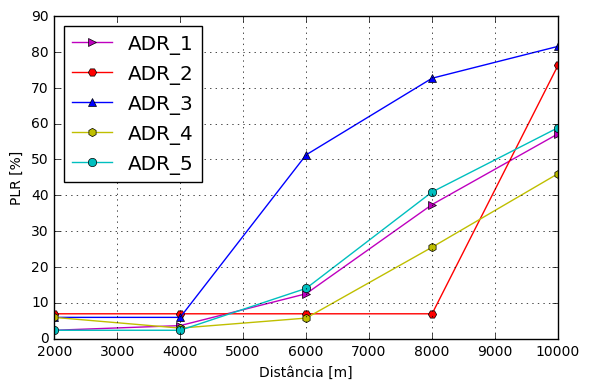

/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices/DadosLora_1_job.txt


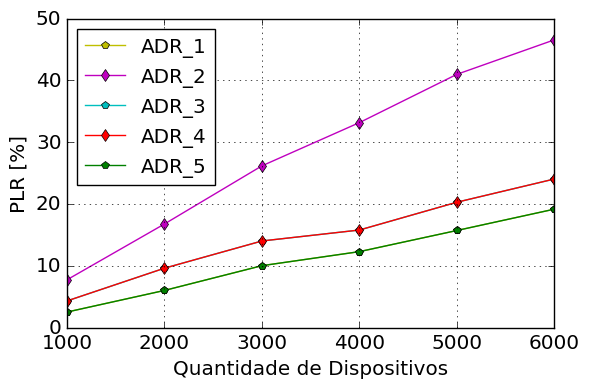

/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius/DadosLora_1_job.txt


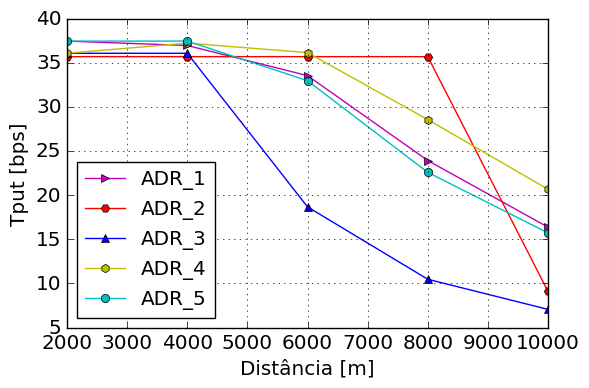

/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices/DadosLora_1_job.txt


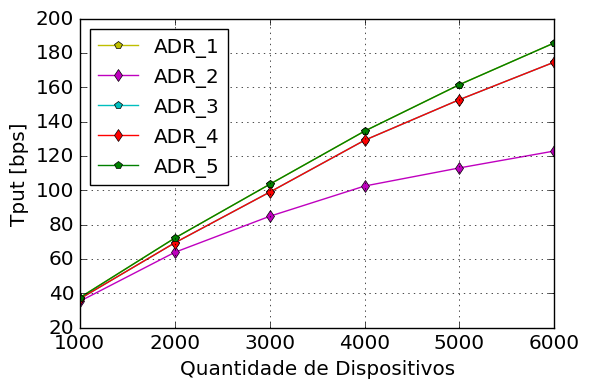

/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius/DadosLora_1_job.txt


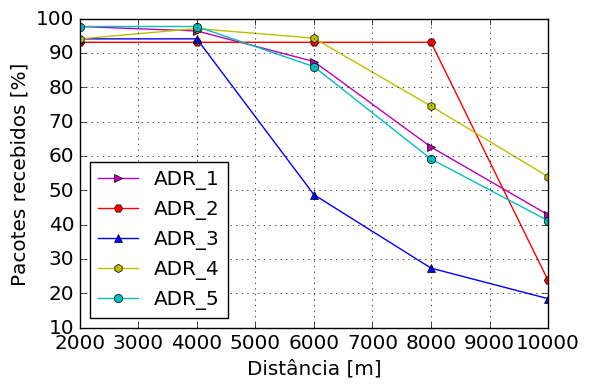

/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices/DadosLora_1_job.txt


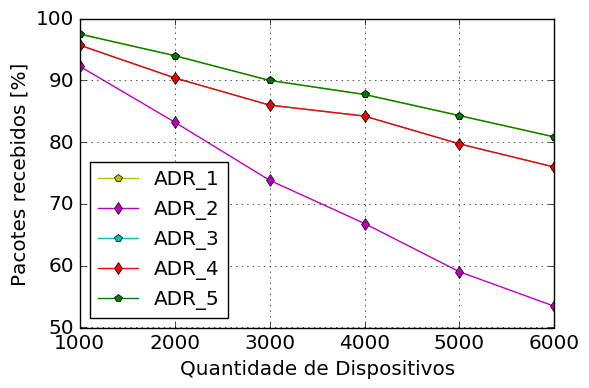

/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius/DadosLora_1_job.txt
/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices/DadosLora_1_job.txt


In [5]:
%run plotScript -f "campanha_1.yaml"

Como a **campanha_1.yaml** foi realizada somente com 1 job (um experimento de Monte Carlo), as figuras não mostram o intervalo de confiança. 

A seguir, o script **plotScript.py** é chamado para plotar os gráficos da outra campanha de simulações criada anteriormente (**campanha_2.yaml**). Como mais de 1 job foi simulado, as figuras mostram o intervalo de confiança para 95% confiança, significando que ao executar o mesmo experimento, a média estará dentro de intervalo informado em 95% das vezes. 

Para a **campanha_2.yaml** (com 10 jobs):

Simulação escolhida: 
['radius', 'nDevices']
/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius/DadosLora_10_jobs.txt


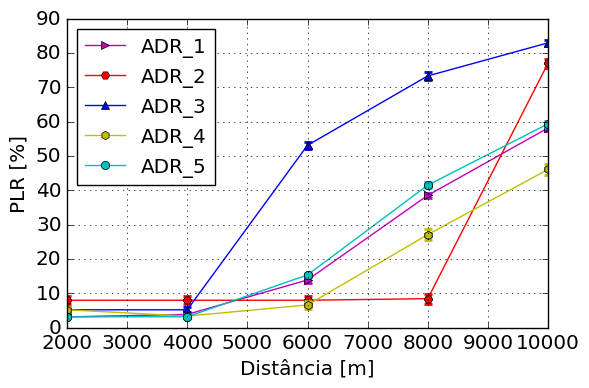

/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices/DadosLora_10_jobs.txt


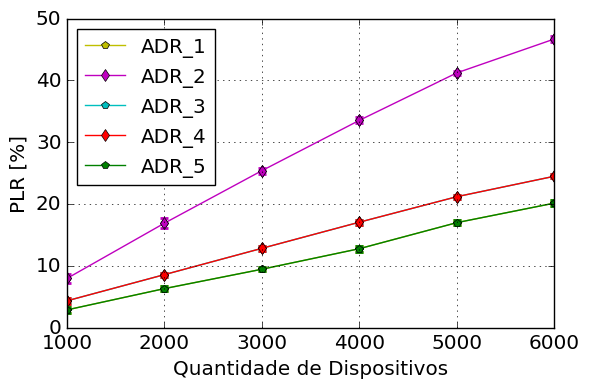

/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius/DadosLora_10_jobs.txt


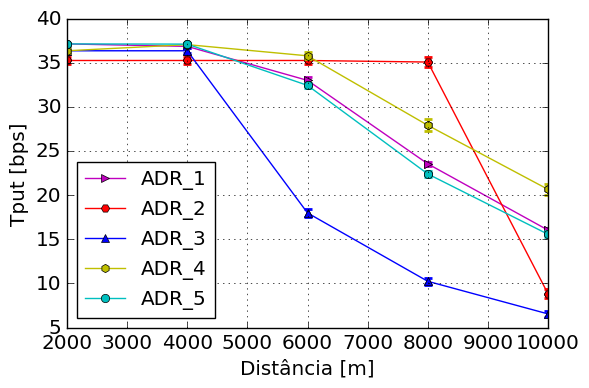

/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices/DadosLora_10_jobs.txt


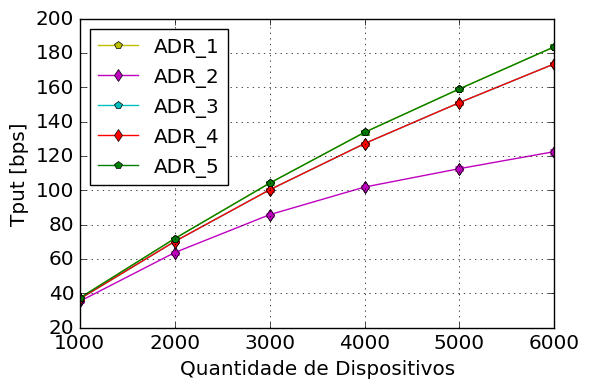

/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius/DadosLora_10_jobs.txt


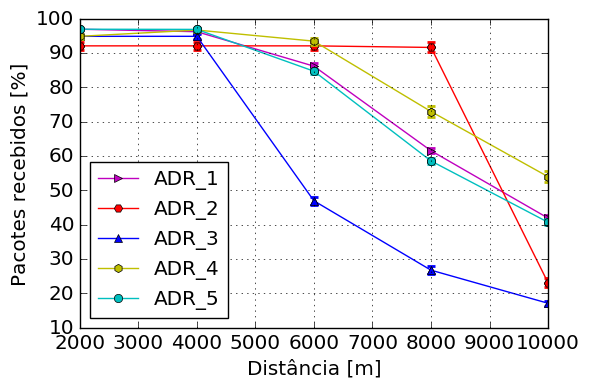

/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices/DadosLora_10_jobs.txt


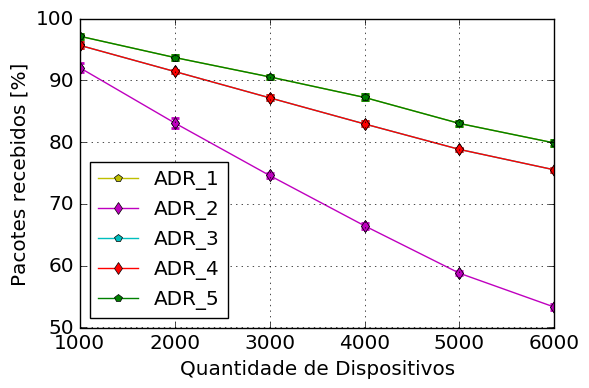

/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_radius/DadosLora_10_jobs.txt
/home/gppcom/ns_3_lora/ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/results_local_nDevices/DadosLora_10_jobs.txt


In [24]:
%run plotScript -f "campanha_2.yaml"

É possível abservar que o intervalo de confiana já é bem pequeno para 10 jobs.